<a href="https://colab.research.google.com/github/vdpyz/TomatoAppleClassifier/blob/main/AppleTomatosClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tomato or apple - classification**

dataset (not rgb files removed): https://www.kaggle.com/datasets/samuelcortinhas/apples-or-tomatoes-image-classification

based on: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Dominika Wegrzyniak, 07.01.2023

In [51]:
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision.transforms import ToTensor
from glob import glob                       # pobranie zawartości katalogu
from PIL import Image                       # wczytanie pliku graficznego

In [52]:
#change to gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [53]:
#!wget https://github.com/vdpyz/TomatoAppleClassifier/blob/main/archive.zip
#!unzip archive

Prepare images to ML
Sizes of images are different -> set all to [100, 100]

In [54]:
class CustomDataset(Dataset):
    def __init__(self, root_dir):
        self.transform = ToTensor()
        classes = glob(f"{root_dir}/*") # pobieramy listę katalogów poszczególnych klas
        self.class_ids = []     # lista indeksów klas
        self.filenames = []     # lista ścieżek i nazw plików

        # generujemy listę plików i indeksów klas
        for id, class_dir in enumerate(classes):
            files = glob(f"{class_dir}/*.jpeg")
            self.filenames.extend(files)    # rozszerzamy listę, a więc extend, a nie append
            self.class_ids.extend([id]*len(files))  # hint: [5]*3 wygeneruje listę [5, 5, 5]

    def __len__(self):
        return len(self.class_ids)

    def __getitem__(self, idx):
        image = Image.open(self.filenames[idx])
        new_image = image.resize((128, 128))
        return self.transform(new_image), self.class_ids[idx]

In [55]:
train_ds = CustomDataset('archive/train')
test_ds = CustomDataset('archive/test')
print(len(train_ds))
print(len(test_ds))

290
97


In [83]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=len(test_ds), shuffle = False)

In [84]:
for X, y in test_dl:
    print(X.shape, y.shape)

torch.Size([97, 3, 128, 128]) torch.Size([97])


Create a CNN model

In [85]:
import torch
import torch.nn as nn

In [118]:
class ConvDownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super(ConvDownBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding)
        self.bn = nn.BatchNorm2d(num_features = out_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)
        return x

In [127]:
model = nn.Sequential(
 ConvDownBlock(3, 8, 3, 1),      # (*, 3, 128, 128) -> (*, 8, 64, 64)
    ConvDownBlock(8, 16, 3, 1),     # -> (*, 16, 32, 32)
    ConvDownBlock(16, 32, 3, 1),    # -> (*, 32, 16, 16)
    ConvDownBlock(32, 64, 3, 1),    # -> (*, 64, 8, 8)
    nn.Flatten(),
    nn.Dropout(0.2),
    nn.Linear(in_features=64*8*8, out_features=64*8),
    nn.ReLU(),
    nn.Linear(in_features=64*8, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=2)
).to(device)

In [128]:
loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [129]:
from sklearn.metrics import confusion_matrix

def my_confusion_matrix(dataloader, classes):
    cm = np.zeros((classes, classes))
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y_pred = model(X).argmax(dim=1).cpu()
            cm += confusion_matrix(y, y_pred)
    return cm

def accuracy(dataloader):
    correct = 0
    all = len(dataloader.dataset)

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X).argmax(dim=1)
            correct += (y_pred == y).sum().item()
    return correct/all

In [130]:
def train_loop():
    total_loss = 0

    for X,y in train_dl:
        X, y = X.to(device), y.to(device)
        opt.zero_grad()

        y_pred = model(X)

        loss = loss_fn(y_pred, y)

        loss.backward()
        opt.step()
        total_loss += loss.item()
        
    return total_loss

In [131]:
loss_history=[]

Epoch: 0 loss: 3.3809890747070312
Epoch: 10 loss: 1.183321051299572
Epoch: 20 loss: 0.10431524057639763
Epoch: 30 loss: 0.15633928054012358
Epoch: 40 loss: 0.12612243462353945
Epoch: 50 loss: 0.006297405692748725
Epoch: 60 loss: 6.718586223541934e-05
Epoch: 70 loss: 7.913763738542912e-06
Epoch: 80 loss: 0.020106044561543968
Epoch: 90 loss: 0.017148886385257356
Epoch: 100 loss: 0.007435448642354459


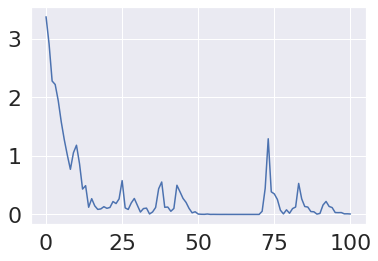

In [132]:
epochs=101
for epoch in range(epochs):
    loss=train_loop()
    loss_history.append(loss)
    if not epoch%10:
        print(f"Epoch: {epoch} loss: {loss}")
plt.plot(loss_history);

In [133]:
accuracy(train_dl), accuracy(test_dl)

(1.0, 0.7628865979381443)

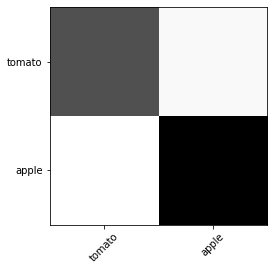

In [117]:
labels = ["tomato", "apple"]
cm=my_confusion_matrix(test_dl, 2)
fig, ax = plt.subplots(1,1)
ax.imshow(cm, cmap="gray_r")

ax.set_xticks(list(range(2)))
ax.set_xticklabels(labels, rotation=45)
ax.set_yticks(list(range(2)))
ax.set_yticklabels(labels);

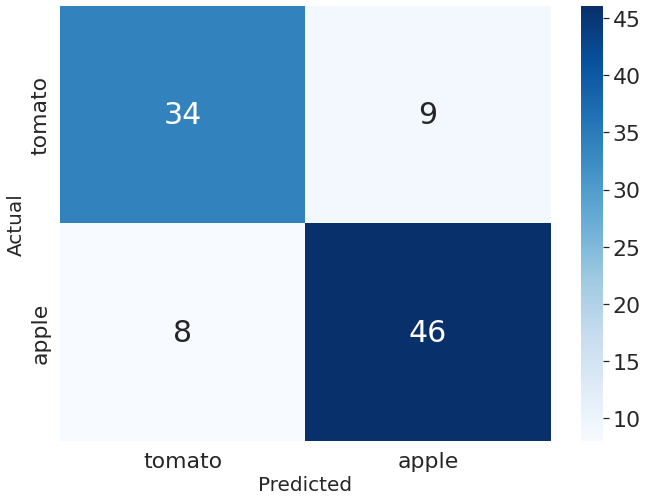

In [135]:
import seaborn as sns
from seaborn import heatmap

plt.figure(figsize=(11,8))
sns.set(font_scale=2)

heatmap(cm,
        annot=True,
        annot_kws={"size": 30},
        fmt='g',
        cmap='Blues',
        xticklabels=labels,
        yticklabels=labels)

plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);